# Notebook to Improve Accuracy of World Coordinate System of Pure Parallel Dataset

## Introduction

In this notebook, we will go through the steps needed to improve the accuracy of the World Coordinate System (WCS) in the headers of pure parallel datasets that were observed with JWST prior to the installation of DMS 10.2 (April 2024). The example dataset is jw01571078001_03201_00001_nis_rate.fits, which is a direct image from pure parallel Program ID 1571 (PI: Malkan). Note that the `update_parallel_wcs.py` script has to be run on all individual datasets taken during a pure parallel visit in order to get the improved WCS for that visit. 

In this notebook, we assume that all relevant files are located in the current working directory.

### Install pipeline and other required packages

The required packages are in the provided file `requirements.txt`. We generally recommend to create a fresh conda environment followed by the installation of those required packages:

```
conda create -n improve_pure_parallel_wcs
conda activate improve_pure_parallel_wcs
pip install -r requirements.txt
```

Date last published: September 3, 2024

### Imports

In [45]:
import copy
import jwst.datamodels as dm
import numpy as np
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.time import Time
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pysiaf
import warnings
import urllib.request
from astroquery.gaia import Gaia
%matplotlib inline

### Define a few functions

In [46]:
# This example is to show the (mis-)alignment of the World Coordinate System of a Pure Parallel imaging dataset 
# taken before the installation of DMS 10.2, relative to GAIA DR3, and how the application of the 
# "update_parallel_wcs.py" script improves that alignment.
#
# First some functions to obtain a catalog of GAIA stars near a certain sky position:
#
def query_gaia(ra, dec, radius, verbose=False, epoch=None, filename=None):
    """
    Execute a Gaia DR3 query using astroquery, return the table of sources.

    Parameters
    ----------

    ra:   a float value, the right ascension in decimal degrees

    dec:  a float value, the declination in decimal degrees

    radius:  an optional float value, the search radius in arc-seconds, 
             default 1.0

    epoch:   an optional float value, the epoch for the positions in decimal 
             years (2023.197588611 for example, for 2021-05-24T17:46:12.814) 
             if given, the proper motion is allowed for in the positions that 
             are returned

    verbose:  an optional boolean value, if True print a list of the sources

    filename:  an optional string value, used as the output file name if 
               the verbose flag is set (if None, print only to the terminal)

    Returns
    -------

    gaiadata1:  a numpy Table variable containing the catalogue of sources

    """
    coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree),
                     frame='icrs')
    radius = u.Quantity(radius/3600.0, u.deg)
    Gaia.ROW_LIMIT = -1
    Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
    gaiadata1 = Gaia.query_object_async(coordinate=coord, width=radius*2, height=radius*2)
    if verbose:
        gphot = gaiadata1['phot_g_mean_mag']
        gbphot = gaiadata1['phot_bp_mean_mag']
        grphot = gaiadata1['phot_rp_mean_mag']
        parallax = gaiadata1['parallax']
        names = gaiadata1['DESIGNATION']
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gabs = gphot-5.*np.log10(1000./parallax)+5.
            gcol = gbphot - grphot
        if epoch is None:
            epoch = 2016.0
        gaiadata2 = apply_precession(gaiadata1, epoch-2016.0)
        ra = gaiadata2['ra']
        dec = gaiadata2['dec']
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for ind in range(len(ra)):
                if (gbphot[ind] < 90.) and (grphot[ind] < 90.):
                    line = '%12.8f %13.8f %10.6f %10.6f %10.6f %10.3f %10.4f %10.4f "%s"' % (ra[ind], dec[ind], gphot[ind], 
                                                                                             gbphot[ind], grphot[ind], parallax[ind], 
                                                                                             gabs[ind], gcol[ind], names[ind])
                    line = line.replace('nan', '0.0')
                else:
                    line = '%12.8f %13.8f %10.6f %10.6f %10.6f %10.3f %10.4f %10.4f "%s"' % (ra[ind], dec[ind], gphot[ind], 
                                                                                             gphot[ind], gphot[ind], parallax[ind], 
                                                                                             gabs[ind], 0.0, names[ind])
                    line = line.replace('nan', '0.0')
            if filename is not None:
                outfile = open(filename, 'w')
                print('          RA           DEC          g        gbp        grp   parallax      abs_g    gbp_grp               GAIA_Designation', file=outfile)
                for ind in range(len(ra)):
                    if (gbphot[ind] < 90.) and (grphot[ind] < 90.):
                        line = '%12.8f %13.8f %10.6f %10.6f %10.6f %10.3f %10.4f %10.4f "%s"' % (ra[ind], dec[ind], gphot[ind], 
                                                                                                 gbphot[ind], grphot[ind], 
                                                                                                 parallax[ind], gabs[ind], gcol[ind], 
                                                                                                 names[ind])
                        line = line.replace('nan', '0.0')
                    else:
                        line = '%12.8f %13.8f %10.6f %10.6f %10.6f %10.3f %10.4f %10.4f "%s"' % (ra[ind], dec[ind], gphot[ind], 
                                                                                                 gphot[ind], gphot[ind], 
                                                                                                 parallax[ind], 
                                                                                                 gabs[ind], 0.0, names[ind])
                        line = line.replace('nan', '0.0')
                    print(line, file=outfile)
                outfile.close()
    return gaiadata1

def apply_precession(catalog, deltat):
    """
    Apply precession to update a catalog of values.  Uses astropy.SkyCoord 
    apply_space_motion to update the positions.

    Parameters:

    catalog:     a numpy Table type variable with elements 'ra', 'dec', 'pmra', 
                 and 'pmdec' as per the Gaia DR3 catalogue; sky coordinates 
                 must be in degrees and the proper motions must be in mas/year

    deltat:      a float value, the time change in decimal years for the motion

    Returns
    -------

    newcatalog:  a copy of catalog with 'newra', 'newdec' elements with the 
                 revised sky positions; if no proper motion data are 
                 available then newra = ra and newdec = dec
    """
    newcatalog = copy.deepcopy(catalog)
    newcatalog['newra'] = catalog['ra']
    newcatalog['newdec'] = catalog['dec']
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sky_coords = SkyCoord(catalog['ra'], catalog['dec'], 
                             unit=(u.deg, u.deg),
                             pm_ra_cosdec=catalog['pmra'], 
                             pm_dec=catalog['pmdec'],
                             obstime=Time('2016-01-01 00:00:00.0'))
        newpos = sky_coords.apply_space_motion(dt=deltat*u.yr)
    newra = newpos.ra.value
    newdec = newpos.dec.value
    newcatalog['newra'] = newra
    newcatalog['newdec'] = newdec
    inds = np.isnan(newra)
    newcatalog['newra'][inds] = newcatalog['ra'][inds]
    newcatalog['newdec'][inds] = newcatalog['dec'][inds]
    return newcatalog


### Get sky coordinates of a list of GAIA targets around the pointing of the pure parallel image

In [47]:
# Now get such a list around pointing of NIRISS pure parallel image jw01571078001_03201_00001_nis_rate.fits
# downloaded from the MAST archive. 
# Note: files downloaded or created here will be placed in the current working directory.
boxlink = 'https://stsci.box.com/shared/static/ydxn3hhndwup0qr85fuyqro6suufa6fx.fits'
boxfile = 'jw01571078001_03201_00002_nis_rate.fits'
urllib.request.urlretrieve(boxlink, boxfile)
imfile = pyfits.open('jw01571078001_03201_00002_nis_rate.fits')
hdr1 = imfile[1].header
ra, dec = (hdr1['CRVAL1'], hdr1['CRVAL2'])
print('RA = {}, DEC = {}'.format(ra, dec))
mygaia = query_gaia(ra, dec, 70., verbose=True, epoch=2022.9968, filename='gaiacoords.out')

RA = 150.41048088035956, DEC = 2.4050524643551943


2024-09-04 18:20:44,075 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


### Convert those sky coordinates to (x, y) in the image according to its WCS, then show them on image

     RA         DEC         x         y    
------------ ---------- --------- ---------
150.41652702 2.39878800 1178.4537  572.5781
150.41591443 2.39797550 1233.7315  582.1378
150.40719349 2.39406168 1646.0505  909.0131
150.42265455 2.40721593  610.8758  484.1616
150.39991658 2.41498142  805.9535 1784.5106
150.42546736 2.41363882  225.3103  506.9972
150.42277119 2.41723805  117.3792  727.9126
150.41347159 2.38794396 1786.8709  450.3341
150.40903516 2.38639945 1974.8806  627.7408
150.42439347 2.42208304 -160.7871  769.1785
150.39277041 2.38668612 2372.8320 1426.5667


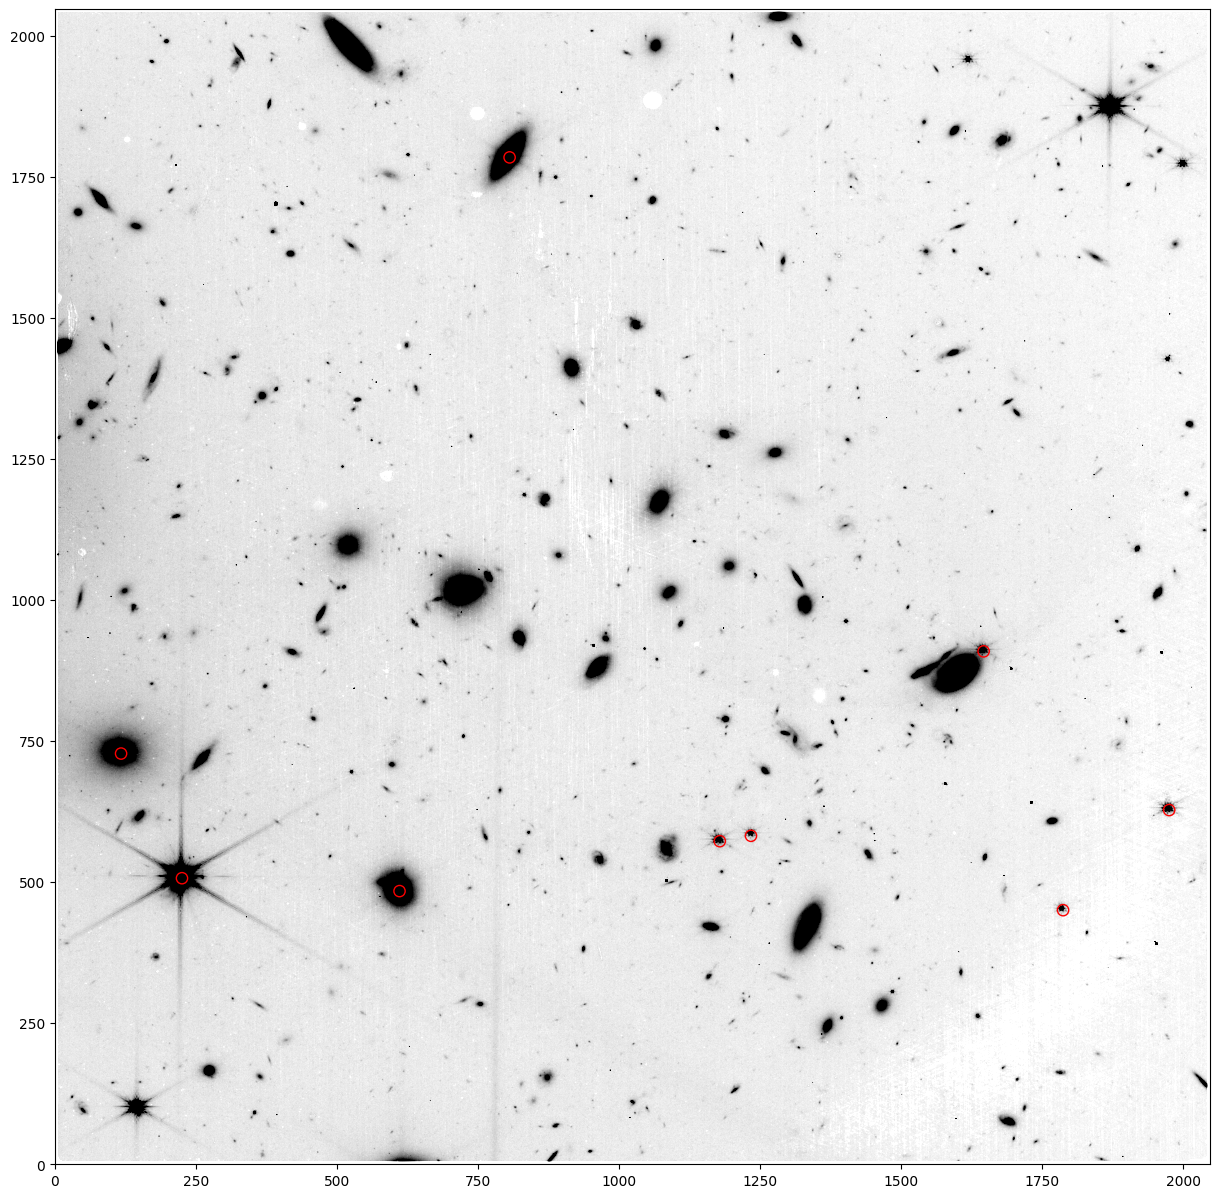

In [48]:
t = ascii.read('gaiacoords.out')
ra, dec = (t['RA'], t['DEC'])
ratefile = 'jw01571078001_03201_00002_nis_rate.fits'
instr = imfile[0].header['INSTRUME']
aperture = imfile[0].header['APERNAME']
siaf = pysiaf.Siaf(instr)
myaper = siaf[aperture]
mod = dm.open(ratefile)
am = pysiaf.utils.rotations.attitude_matrix(0, 0, mod.meta.pointing.ra_v1,
                                            mod.meta.pointing.dec_v1,
                                            mod.meta.pointing.pa_v3)
myaper.set_attitude_matrix(am)
x, y = myaper.sky_to_sci(ra, dec)

xytab = Table([ra, dec, x, y], names=('RA','DEC','x', 'y'))
xytab['RA'].info.format = '.8f'
xytab['DEC'].info.format = '.8f'
xytab['x'].info.format = '.4f'
xytab['y'].info.format = '.4f'
print(xytab)

ys, xs = imfile[1].data.shape
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
xsize, ysize = (20, 20)
for i in range(len(t)):
    ax.add_patch(patches.Ellipse(
        (x[i], y[i]),
        (xsize),
        (ysize), fill=False, color='red'))
    i += 1
# Create image with bad pixels interpolated over (for display purposes)
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel
kernel = Gaussian2DKernel(x_stddev = 2)
fixed_image = interpolate_replace_nans(imfile[1].data, kernel)
ax.imshow(fixed_image, cmap='binary', origin='lower', extent=[0, xs-1, 0, ys-1], vmin=0.7, vmax=2)

Note that the WCS is 'off' by more than a pixel, which is a problem for spectral extraction in the pipeline for WFSS data, since **that extraction relies blindly on the accuracy of the WCS**. 

### Now apply the update_parallel_wcs.py script to correct the WCS. Note the offset in pixel coordinates calculated by the script:

In [49]:
# This cell assumes that you have script update_parallel_wcs.py in your working directory. 
# Note: Outside of this notebook, this script should be run as follows on each _rate.fits file in the pure parallel visit:
# 
# python update_parallel_wcs.py my_rate.fits <verbosity>
# 
# After the script has been run on the input file(s), one can then (re-)run Stage 2 of the JWST calibration pipeline 
# (`calwebb_image2` and/or `calwebb_spec2`) on those files, which will now result in correct WCSes in the data headers 
# (and corrected locations of spectral extractions in case of pure parallel WFSS data).
#
# By default, `update_parallel_wcs.py` displays the input and output values of the CRVAL1/2 keywords when the script is run 
# as seen below. One can avoid this by setting the optional parameter <verbosity> to anything other than `True`.
#
# The script keeps track of its executions using a log file called "pure_parallel_wcs_logfile" in the working directory.

%run update_parallel_wcs.py jw01571078001_03201_00002_nis_rate.fits

PureParallelUtils.update_pure_parallel_wcs: File: jw01571078001_03201_00002_nis_rate.fits
PureParallelUtils.update_pure_parallel_wcs: FGS: jw01762008001_gs-fg_2022364021322_cal.fits 
PureParallelUtils.update_pure_parallel_wcs: original crval 150.4104809 2.4050525
PureParallelUtils.update_pure_parallel_wcs:      new crval 150.4104774 2.4050775
PureParallelUtils.update_pure_parallel_wcs:           dpix -1.139  0.792


<Figure size 640x480 with 0 Axes>

### Calculate (x, y) for the GAIA targets in the updated fits file and print the updated (x, y) coordinates:

In [50]:
imfile = pyfits.open('jw01571078001_03201_00002_nis_rate.fits')
hdr0 = imfile[0].header
myaper = pysiaf.Siaf(hdr0['INSTRUME'])[hdr0['APERNAME']]
mod = dm.open('jw01571078001_03201_00002_nis_rate.fits')
am = pysiaf.utils.rotations.attitude_matrix(0, 0, mod.meta.pointing.ra_v1,
                                            mod.meta.pointing.dec_v1,
                                            mod.meta.pointing.pa_v3)
myaper.set_attitude_matrix(am)
newx, newy = myaper.sky_to_sci(ra, dec)
xytab = Table([x, y, newx, newy], names=('x', 'y', 'x_corr', 'y_corr'))
for col in xytab.colnames:
    xytab[col].info.format = '.4f'
print(xytab)

# In practice, one would run the script on all _rate.fits files for a given target, 
# then run the stage-2 and stage-3 pipelines on the resulting images 
# (specifically, Image2Pipeline for the direct images, followed by Image3Pipeline to create a combined 
# image and source catalog, followed by the stage-2 and stage-3 pipelines for the grism images 
# (Spec2Pipeline and Spec3Pipeline, respectively).

    x         y       x_corr    y_corr 
--------- --------- --------- ---------
1178.4537  572.5781 1179.3692  573.1124
1233.7315  582.1378 1234.6468  582.6729
1646.0505  909.0131 1646.9603  909.5544
 610.8758  484.1616  611.7927  484.6867
 805.9535 1784.5106  806.8472 1785.0388
 225.3103  506.9972  226.2269  507.5160
 117.3792  727.9126  118.2918  728.4293
1786.8709  450.3341 1787.7893  450.8782
1974.8806  627.7408 1975.7960  628.2877
-160.7871  769.1785 -159.8752  769.6907
2372.8320 1426.5667 2373.7343 1427.1210
